In [ ]:
import re
import pickle
import logging
import dataclasses
from collections import Counter
from collections import defaultdict
from typing import List, Dict, Optional

import torch
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt

# Redes Neuronales Recurrentes: Generación de texto

En este cuaderno de Jupyter, exploraremos el uso de redes neuronales recurrentes (RNN) en la tarea de generación de texto. El objetivo es entrenar un modelo capaz de generar texto apegado al estilo literario de J.R.R. Tolkien, autor del Señor de los Anillos. A lo largo del cuaderno, abordaremos diferentes aspectos de este proceso: la preparación del conjunto de datos, la definición y entrenamiento del modelo, la generación de sequencias de texto originales y el análisis de resultados.

1. Procesamiento del conjunto de datos:
    - Lectura y explicación de conjunto de entrenamiento.
    - Procesamiento de datos, se definen los símbolos que se utilizarán para entrenar al modelo.
    - Cálculo de estadísticas básicas: número palabras y número de palabras únicas.
2. Carga y procesamiento de embeddings:
    - Uso de embeddings previamente entrenados.
    - Generación de diccionarios para mapear palabras a índices y vice versa. Nos ayudara en la fase de entrenamiento para codificar la entrada al modelo y decodificar la salida de este.
    - Análisis de palabras faltantes en embeddings. Se generarán nuevos embeddings para las palabras faltantes.
    - Generación de secuencias de entrenamiento. Se definen las instancias de entrenamiento y los objetivos correspondientes.
3. Definición y entrenamiento de modelo:
    - Definición de modelo RNN utilizando PyTorch.
    - Definición de hiperparámetros, optimizador, función de pérdida y Codificación del ciclo de entrenamiento.
    - Gráfica de pérdida y exactitud a lo largo de las épocas.
4. Busqueda de hiperparámetros y generación de secuencias:
    - Entrenamiento de modelos buscando los mejores parámetros.
    - Análisis de gradientes entre modelos.
    - Generación de secuencias.

# 1. Procesamiento del conjunto de datos

In [ ]:
# book.txt contiene el libro de La Comunidad del Anillo, primero libro de la trilogía
with open("book.txt", "rt") as f:
    book_string = f.read()

# Convertir caracteres a minúsculas
book_string_lower = "".join(c.lower() for c in book_string)

# Extraer párrafos
# En la línea 7 se eliminan todos los saltos de línea para ya que book.txt introduce
# saltos de línea para dar formato al libro.
paragraphs = book_string_lower.split("\n\n")
paragraphs = [p.strip() for p in paragraphs]
paragraphs = [p.replace("\n", "") for p in paragraphs]

# Imprimir el # de párrafos y los primeros 3
print(f"El libro contiene {len(paragraphs)} párrafos", end="\n\n")
print(f"paragraphs[0]:\n{paragraphs[0]}", end="\n\n")
print(f"paragraphs[1]:\n{paragraphs[1]}", end="\n\n")
print(f"paragraphs[2]:\n{paragraphs[2]}")

El libro contiene 1700 párrafos

paragraphs[0]:
cuando el señor bilbo bolsón de bolsón cerrado anunció que muy pronto celebraría su cumpleaños centésimo decimoprimero con una fiesta de especial magnificencia, hubo muchos comentarios y excitación en hobbiton. bilbo era muy rico y muy peculiar y había sido el asombro de la comarca durante sesenta años, desde su memorable desaparición e inesperado regreso. las riquezas que había traído de aquellos viajes se habían convertido en leyenda local y era creencia común, contra todo lo que pudieran decir los viejos, que en la colina de bolsón cerrado había muchos túneles atiborrados de tesoros. como si esto no fuera suficiente para darle fama, el prolongado vigor del señor bolsón era la maravilla de la comarca. el tiempo pasaba, pero parecía afectarlo muy poco. a los noventa años tenía el mismo aspecto que a los cincuenta. a los noventa y nueve comenzaron a considerarlo «bien conservado», pero «sin cambios» hubiese estado más cerca de la verdad. 

In [ ]:
book_string_lower = "\n".join(paragraphs)  # Esto reemplaza \n\n por \n en la separación de párrafos
book_string_lower[:2_000]

'cuando el señor bilbo bolsón de bolsón cerrado anunció que muy pronto celebraría su cumpleaños centésimo decimoprimero con una fiesta de especial magnificencia, hubo muchos comentarios y excitación en hobbiton. bilbo era muy rico y muy peculiar y había sido el asombro de la comarca durante sesenta años, desde su memorable desaparición e inesperado regreso. las riquezas que había traído de aquellos viajes se habían convertido en leyenda local y era creencia común, contra todo lo que pudieran decir los viejos, que en la colina de bolsón cerrado había muchos túneles atiborrados de tesoros. como si esto no fuera suficiente para darle fama, el prolongado vigor del señor bolsón era la maravilla de la comarca. el tiempo pasaba, pero parecía afectarlo muy poco. a los noventa años tenía el mismo aspecto que a los cincuenta. a los noventa y nueve comenzaron a considerarlo «bien conservado», pero «sin cambios» hubiese estado más cerca de la verdad. había muchos que movían la cabeza pensando que 

In [ ]:
# Separamos todas las palabras del libro. Vamos a utilizar los símbolos ¡ ! ¿ ? " ' ( ) - . : ; , « » \n como
# palabras propias para que el modelo aprenda a utilizarlos; adicionalmente, no se utilizarán números para
# este propósito.
pattern = r"(\s|¡|!|¿|\?|\"|\'|\(|\)|\-|\.|\:|\;|\,|«|»)"
words = re.split(pattern, book_string_lower)
words = [w for w in words if w and w != ' ' and not w.isnumeric()]
unique_words = set(words)

In [ ]:
print(f"Total words: {len(words):,}")
print(f"Unique words: {len(unique_words):,}")

Total words: 104,073
Unique words: 9,432


# 2. Carga y procesamiento de embeddings

El modelo que vamos a entrenar, al contrario que el del cuaderno pasado, utiliza palabras y no letras, esto es, dada una secuencia de palabras predice la siguiente. Una vez más, podemos utilizar la representación "one-hot" para codificar cada una de las 9,428 palabras de nuestro vocabulario; sin embargo, además de que esta representación utiliza una gran cantidad de memoria carece de un significado semántico. Consideremos las siguiente dos frases:

- El día de ayer leí un libro
- El día de ayer leú un artículo

Supongamos que tenemos un vocabulario que consta de 3 palabras $\left\{ libro, artículo, perro \right\}$ y utilizando la codificación "one-hot" generamos las siguientes representaciones: $o_{libro} = \left[ 1, 0, 0 \right]^T$, $o_{artículo} = \left[ 0, 1, 0 \right]^T$ and $o_{artículo} = \left[ 0, 0, 1 \right]^T$ en donde se utiliza la notación $o_{palabra}$ para denotar la representación de una palabra utilizando el método "one-hot encoding". Bajo esta codificación, la representación de cada palabra es ortogonal a la representación de las otras pese a que semánticamente la palabra "libro" es más parecida a la palabra "articulo" que a la palabra "perro".

Una forma de utilizar el significado semántico de las palabras en su representación vectorial es utilizando "embeddings" en donde vectores con significado semántico parecido tienen una gran similitud. En la figura 1 se muestra este contraste, en la izquierda vemos que las representaciones de las palabras "libro" y "artículo" son ortogonales entre sí mientras que la representación de estas usando embedding las muestra mucho más cercandas. Dos medidas de similitud utilizadas comúnmente son el producto punto (ángulo entre vectores) y la distancia euclideana.

Existen diferentes métodos para cálcular estos "embeddings"; sin embargo, no es un objetivo del cuaderno detallar estos. Para el entrenamiento de nuestro modelo utilizaremos "embeddings" previamente calculados. Los "embeddings" que usaremos se pueden descargar [aquí](https://github.com/dccuchile/spanish-word-embeddings), de manera específica, usaremos los embeddings que contienen 1,000,653 vectores de dimensión 300 entrenados en el corpus "Spanish Billion WOrd Corpus" con el algoritmo "Word2Vec".

In [ ]:
# Para facilitar el procesamiento de los embeddings, se ha preparado el archivo "word_to_index.pkl"
# que contiene un diccionario que mapea palabras a índices para cada una de las 1,000,653 palabras
# de los embeddings pre-computados. Este diccionario nos ayudará a convertir palabras a índices
# para ser usados en el modelo y a convertir índices a palabras para procesar la salida del
# modelo.
with open("word_to_index.pkl", "rb") as file:
    corpus_word_to_index: Dict[str, int] = pickle.load(file)

# Algunas palabras del diccionario corpus_word_to_index vienen repetidas ya que una misma palabra
# puede aparecer tanto en mayúsculas como en minúsculas. Para abordar este problema, creamos un
# nuevo diccionario que contenga únicamente la primera instancia de cada palabra.
word_to_index = {}
for k, v in corpus_word_to_index.items():
    if k.lower() not in word_to_index:
        word_to_index[k.lower()] = v

# El número de palabras en nuestro conjunto de datos es mucho menos que el de los embeddings pre-computados
# por lo que filtraremos el diccionario word_to_index para que solo contenga palabras que aparecen en nuestro
# conjunto de datos.
word_to_index = {k: v for k, v in word_to_index.items() if k in unique_words}

# Imprimir los primeros cinco elementos del diccionario word_to_index
for key, value in list(word_to_index.items())[:5]:
    print(key, value)

de 0
la 2
en 3
el 4
y 5


In [ ]:
# Lo siguiente es encontrar el conjunto de palabras de nuestro dataset que no tienen un embedding.
missing_words = sorted(unique_words - set(word_to_index.keys()))
print(f"Hay {len(missing_words)} palabras que no tienen un embedding")
print(f"Palabras sin embeddings:\n{missing_words}")

Hay 195 palabras que no tienen un embedding
Palabras sin embeddings:
['\n', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'acortaréis', 'adelgazo', 'agazapándose', 'agriará', 'agrisándose', 'ahorrándote', 'alojaréis', 'andabais', 'aparecerías', 'aplastéis', 'apresurarte', 'apretaos', 'apáguenlo', 'arruinaste', 'atisbándonos', 'atormentarles', 'atraganté', 'atrancando', 'atrancaremos', 'aturdidamente', 'balaron', 'barahi', 'bardados', 'bolgovado', 'bombadillo', 'bombadilló', 'borgil', 'bufaban', 'cabalgaran', 'calentarles', 'caminéis', 'cantamosen', 'carcomiéndose', 'centellearon', 'chamuscándola', 'ciñatiesa', 'clavaré', 'compadecí', 'complácele', 'confiaras', 'corrieras', 'crepitaron', 'culebreaba', 'cántela', 'cántenos', 'cíñatiesa', 'demorarte', 'desanimadamente', 'desaparezcas', 'desarreglé', 'desconfiadamente', 'descoronado', 'desensillados', 'deslizárselo', 'desocupándose', 'despidiéndote', 'dilló', 'diló', 'distraeré', 'dospiés', 'díantres', 'empacaremos', 'empalidecien

In [ ]:
# Analizando las palabras faltantes, vemos que entre estas se encuentran los símbolos de puntuación.
# Tenemos dos opciones:
# 1. Podemos definir un token especial "<UNK>" ("unknown") que reemplace a todas estas palabras que no tienen
#     embedding. En algunas circunstancias esto puede funcionar; sin embargo, el modelo no aprendería
#     a utilizar estas palabras.
# 2. Podemos extender los embeddings existentes con estas palabras, para esto, crearíamos embeddings de estas
#     y los inicializaríamos de forma aleatoria; además, estos serían parámetros del modelo a optimizar.
# La decisión entre la opción uno y dos depende del problema y del objetivo que se tenga, en este cuaderno
# tomaremos la segunda opción.

In [ ]:
# El siguiente paso es extender los embeddings, para esto, inicializamos los embeddings faltantes con una
# distribución normal con media y desviación estandar igual a cero y uno respectivamente,también normalizaremos
# los vectores para que tengan una norma l2 igual a uno. El archivo "embeddings_vectors_300.pt" contiene un
# tensor de PyTorch de tamaño (N, 300) en donde N es el número de embeddings y 300 es el tamaño de cada uno.
embedding_weights = torch.load("embeddings_vectors_300.pt")
embedding_weights = embedding_weights[list(word_to_index.values())]  # Filtrar embeddings de dataset
word_to_index = {k: i for i, k in enumerate(word_to_index.keys())}  # Resetear índices
# Imprimimos las dimensiones del embedding antes de extenderlos
print(f"Dimenciones iniciales de 'embedding_weights': {embedding_weights.shape}")

embedding_dim = 300
for w in missing_words:
    random_embedding = np.random.normal(0, 1, size=embedding_dim)
    normalized_embedding = random_embedding / np.linalg.norm(random_embedding)
    # Se usa método unsqueeze para convertir el tensor de dimension (n,) a (1, n)
    new_embedding = torch.tensor(normalized_embedding, dtype=torch.float32).unsqueeze(0)
    embedding_weights = torch.cat((embedding_weights, new_embedding), dim=0)
    word_to_index[w] = max(word_to_index.values()) + 1
index_to_word = {v: k for k, v in word_to_index.items()}
print(f"Dimenciones finales de 'embedding_weights': {embedding_weights.shape}")

Dimenciones iniciales de 'embedding_weights': torch.Size([9237, 300])
Dimenciones finales de 'embedding_weights': torch.Size([9432, 300])


In [ ]:
# Crear las instancias de entrenamiento. Cada instancia es una secuencia de 51 palabras. Se usarán las primeras
# 50 palabras para predecir la palabra 51.
sequences: List[str] = []
for i in range(len(words) - 50):
    sequences.append(" ".join(words[i: i + 51]))
print(f"Hay {len(sequences):,} sequencias de entrenamiento")

# Convertir las secuencias de texto en secuencias de digitos, de la misma manera, necesitamos codificar el
# objetivo del modelo utilizando one-hot-encoding
X, Y = torch.empty((len(sequences), 50), dtype=torch.long), torch.empty((len(sequences), len(unique_words)), dtype=torch.long)
for i, sequence in enumerate(sequences):
    numeric_sequence = []
    splitted_sequence = sequence.split(" ")
    for word in splitted_sequence[:-1]:  # Saltamos el último elemento ya que es el objetivo
        numeric_sequence.append(word_to_index[word])
    X[i] = torch.tensor(numeric_sequence, dtype=torch.long)
    last_word_index = word_to_index[splitted_sequence[-1]]
    Y[i] = torch.nn.functional.one_hot(torch.tensor(last_word_index), num_classes=len(unique_words))
print(f"{X.shape}, {Y.shape}")

Hay 104,023 sequencias de entrenamiento
torch.Size([104023, 50]), torch.Size([104023, 9432])


# 3. Definición y entrenamiento de modelo

In [ ]:
class TextGenerationModel(torch.nn.Module):
    """Modelo para la generación de texto,se compone de una capa de embeddings seguido
    de la capa con la red recurrente y finalmente se agregan dos capas densas para realizar
    la predicción de la siguiente palabra.
    """

    def __init__(self, embeddings, hidden_size, num_layers, output_size):
        """
        :param embeddings: Pesos pre-entrenados a usar en la capa de embeddings.
        :param hidden_size: Tamaño del estado oculto de la red recurrentente.
        :param num_layers: Número de capas de la red recurrente.
        :param output_size: Tamaño de la salida de la red.
        """
        super(TextGenerationModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings, freeze=False)
        # El parámetro batch_first indica los tensores de entrada y salida de la RNN tendrán
        # al tamaño de bache en su primera dimensión.
        self.rnn = torch.nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.fc2 = torch.nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x):
        # Regresa el embedding de dimensión 300 de cada palabra.
        x = self.embedding(x)
        # Regresa un tensor de dimensiones (N, L, H) en donde L es el tamaño de la secuencia y H
        # es el tamaño del estado oculto. Contiene los estados ocultos de la última capa de la RNN.
        x, _ = self.rnn(x)
        # Obtenemos los estados ocultos de la última capa de la última celda de todo el bache.
        x = x[:, -1, :]
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# La siguiente clase contendrá los resultados de cada experimento
@dataclasses.dataclass
class ExperimentResult:
    num_layers: int
    hidden_size: int
    loss_history: List[float]
    accuracy_history: List[float]
    gradients: Optional[Dict[str, float]] = None


# Función de entrenamiento del modelo
def train_model(
    num_layers: int,
    hidden_size: int,
    device: torch.device,
    logger: logging.Logger,
    epochs: int = 200,
    batch_size: int = 256,
    track_gradients: bool = False,
    save_model: bool = True
) -> ExperimentResult:
    """
    :param num_layers: Número de capas de la red recurrente.
    :param device: Dispositivo en donde entrenar el modelo.
    :param logger: Logger objetivo en donde mostrar mensajes de avance.
    :param epochs: Número de épocas por entrenar.
    :param batch_size: Tamaño de bache por entrenar.
    :param track_gradients: Cuando es igual a True se lleva el registro de los gradientes del modelo.
    :param save_model: Determina si se guarda el modelo en disco al terminar el entrenamiento.
    """
    logger.info(f"Inicio de entrenamiento")
    logger.info(f"epochs: {epochs}, num_layers: {num_layers}, hidden_size: {hidden_size}")
    model = TextGenerationModel(embedding_weights, hidden_size, num_layers, output_size=len(unique_words))
    model.to(device)
    loss_history, accuracy_history = [], []
    gradients = defaultdict(int)
    num_batches = X.shape[0] // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        epoch_loss = 0  # Registro de la pérdida total en la época
        epoch_correct = 0  # Registro de predicciones correctas para el cálculo de la exactitud
        for i in range(num_batches):
            # Extraer los baches de entrenamiento
            start = i * batch_size
            end = (i + 1) * batch_size
            x_batch = X[start:end].to(device)
            y_batch = Y[start:end].to(device)

            # Propagación hacia adelante
            output = model(x_batch)

            # Cálculo de la pérdida. La función espera dos argumentos input y target. En este
            # caso el input es la salida del modelo, esta tiene que ser un tensor de dimensiones
            # (N, C) donde C es el número de clases y el objetivo tiene que ser un tensor de
            # dimensión (N, ) con los índices de las clases reales.
            loss = loss_function(output, torch.argmax(y_batch, dim=1))
            epoch_loss += loss

            # Retropropagacióny registro de gradients
            optimizer.zero_grad()
            loss.backward()

            if track_gradients:
                gradients["rnn_weight_hh_l0"] += model.rnn.weight_hh_l0.grad
                gradients["rnn_weight_hh_l1"] += model.rnn.weight_hh_l1.grad

            optimizer.step()

            # Cálculo de estadísticas
            with torch.no_grad():
                predicted = torch.argmax(output, dim=1)
                target = torch.argmax(y_batch, dim=1)
                epoch_correct += (predicted == target).sum().item()

        loss_history.append((epoch_loss / len(X)).item())
        accuracy_history.append(epoch_correct / len(X))
        logger.info(f"epoch: {epoch + 1}/{epochs}, loss: {epoch_loss / len(X)}, accuracy: {epoch_correct / len(X)}")

    # Guardar modelo en disco
    if save_model:
        model.to(torch.device("cpu"))
        torch.save(model.state_dict(), f"models/model_num_layers_{num_layers}_hidden_size_{hidden_size}.pt")

    return ExperimentResult(num_layers, hidden_size, loss_history, accuracy_history, gradients)

In [ ]:
# # Definición de hiperparámetros
# num_layers = 2
# hidden_size = 64
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Configuracción de Logger
# logger = logging.getLogger("rnn_stram")
# logger.setLevel(logging.DEBUG)
# handler = logging.StreamHandler()
# handler.setLevel(logging.DEBUG)
# logger.addHandler(handler)

# # Entrenamiento de modelo
# experiment_result = train_model(num_layers, hidden_size, device, logger, epochs=100, save_model=False)

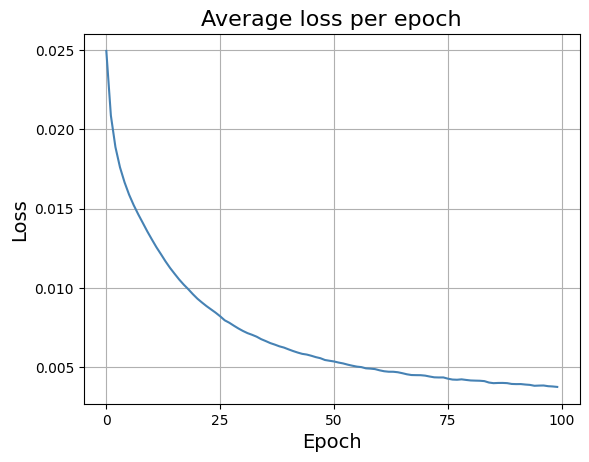

In [ ]:
# Graficar la pérdida promedio por época
with open("loss_history.txt", "rt") as f:
    loss_history = [float(x) for x in f.read().split("\n")]

plt.plot(loss_history, color='steelblue')
plt.xticks(np.arange(0, len(loss_history) + 1, 25))
plt.title("Average loss per epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.show()

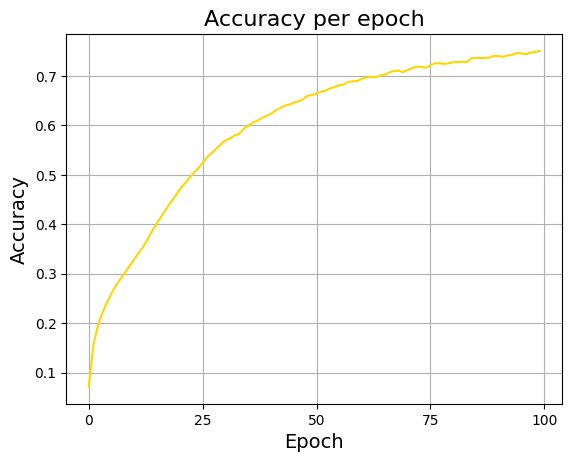

In [ ]:
# Graficar la exactitud por época
with open("accuracy_history.txt", "rt") as f:
    accuracy_history = [float(x) for x in f.read().split("\n")]

plt.plot(accuracy_history, color='gold')
plt.xticks(np.arange(0, len(loss_history) + 1, 25))
plt.title("Accuracy per epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.show()

# 4. Busqueda de hiperparámetros y generación de secuencias

In [ ]:
# # Definición de hiperparámetros
# possible_num_layers = [2, 3]
# possible_hidden_size = [64, 128, 256, 512]
# combinations = [(l, h) for l in possible_num_layers for h in possible_hidden_size]
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Configuracción de Logger
# logger = logging.getLogger("rnn_file_logger")
# logger.setLevel(logging.DEBUG)
# handler = logging.FileHandler("rnn_logger.log", "w")
# handler.setLevel(logging.DEBUG)
# logger.addHandler(handler)

# # Entrenamiento de modelo
# results = []
# for num_layers, hidden_size in combinations:
#     print(f"hidden_size, num_layers: {hidden_size}, {num_layers}")
#     experiment_result = train_model(num_layers, hidden_size, device, logger, epochs=200)
#     results.append(experiment_result)

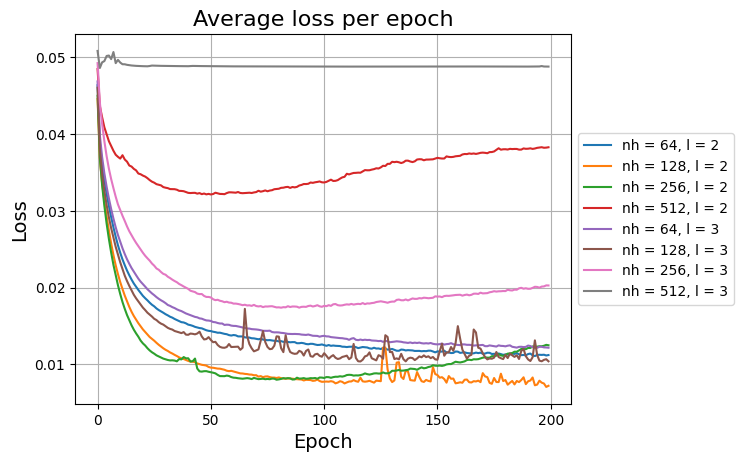

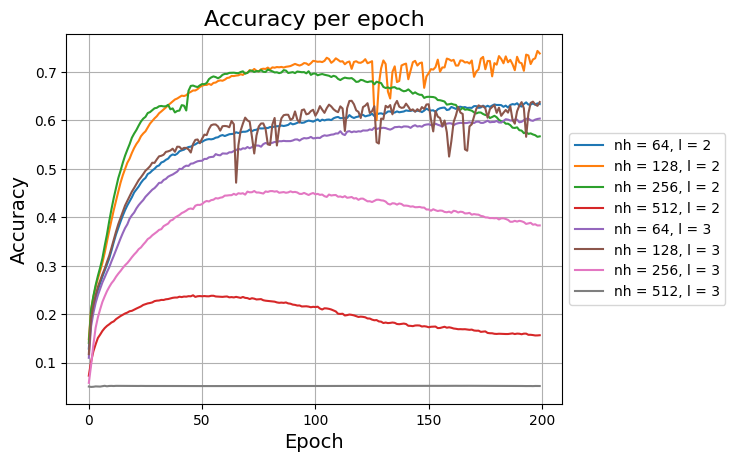

In [ ]:
with open("hyperparameter_search_resutls.pkl", "rb") as f:
    results = pickle.load(f)

# Graficar la perdida promedio por epoca
for r in results:
    plt.plot(r.loss_history, label=f"nh = {r.hidden_size}, l = {r.num_layers}")
plt.xticks(np.arange(0, len(results[0].loss_history) + 1, 50))
plt.title("Average loss per epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

# Graficar la exactitud por epoca
for r in results:
    plt.plot(r.accuracy_history, label=f"nh = {r.hidden_size}, l = {r.num_layers}")
plt.xticks(np.arange(0, len(results[0].accuracy_history) + 1, 50))
plt.title("Accuracy per epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar un modelo pequeño
logger = logging.getLogger("rnn_small_model")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

torch.manual_seed(0)
experiment_result_1 = train_model(2, 64, device, logger, epochs=1, track_gradients=True, save_model=False)
gradients_small_model = {k: v.mean().item() for k, v in experiment_result_1.gradients.items()}

# Entrenar un modelo grande
logger = logging.getLogger("rnn_large_model")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

torch.manual_seed(0)
experiment_result_2 = train_model(20, 64, device, logger, epochs=1, track_gradients=True, save_model=False)
gradients_large_model = {k: v.mean().item() for k, v in experiment_result_2.gradients.items()}

Inicio de entrenamiento
epochs: 1, num_layers: 2, hidden_size: 64
epoch: 1/1, loss: 0.025694966316223145, accuracy: 0.05309402728242792
Inicio de entrenamiento
epochs: 1, num_layers: 20, hidden_size: 64
epoch: 1/1, loss: 0.025969719514250755, accuracy: 0.05204618209434452


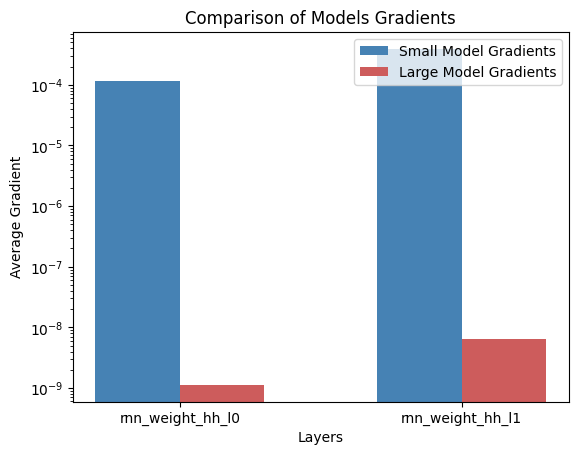

In [ ]:
# Graficar los gradientes de ambos modelos
keys = sorted(set(gradients_small_model.keys()) | set(gradients_large_model.keys()))
values_1 = [abs(gradients_small_model[key]) for key in keys]
values_2 = [abs(gradients_large_model[key]) for key in keys]

# Definir ancho y posición de barras
bar_width = 0.3
positions_1 = np.arange(len(keys)) - bar_width / 2
positions_2 = np.arange(len(keys)) + bar_width / 2

# Creación de la gráfica de barras
plt.bar(positions_1, values_1, width=bar_width, label="Small Model Gradients", color='steelblue')
plt.bar(positions_2, values_2, width=bar_width, label="Large Model Gradients", color='indianred')

# Set the x-axis labels and ticks
plt.xticks(np.arange(len(keys)), keys)

# Utilizar escala logarítmica para el eje y
plt.yscale("log")

# Agregar leyenda, título y etiquetas
plt.legend()
plt.title("Comparison of Models Gradients")
plt.xlabel("Layers")
plt.ylabel("Average Gradient")

plt.show()

In [ ]:
torch.manual_seed(2)
# Generar secuencias con el mejor modelo
model = TextGenerationModel(embedding_weights, 64, 2, output_size=len(unique_words))
model.load_state_dict(torch.load("models/model_num_layers_2_hidden_size_64.pt"))
model.eval()

def generate_sequence(start_index: int, sequence_length: int = 200) -> None:
    generated_sentence = []
    input = X[[start_index]]
    for i in range(sequence_length):
        with torch.no_grad():
            output = model(input)
        output_index = torch.argmax(output, dim=1).item()
        input = torch.cat((input[:, 1:], torch.tensor([[output_index]], dtype=torch.long)), dim=1)
        generated_sentence.append(index_to_word[output_index])
    print(f"Prompt:\n{' '.join([index_to_word[x.item()] for x in X[start_index]])}")
    print(f"Completion:\n{' '.join(generated_sentence)}", end="\n\n")

for i in [0, 1_000, 2_000]:
    generate_sequence(start_index=i)

Prompt:
cuando el señor bilbo bolsón de bolsón cerrado anunció que muy pronto celebraría su cumpleaños centésimo decimoprimero con una fiesta de especial magnificencia , hubo muchos comentarios y excitación en hobbiton . bilbo era muy rico y muy peculiar y había sido el asombro de la comarca durante sesenta años
Completion:
, y al fin esté una piedra , seguido de él . y yo lo abrió el hobbit . 
 los hobbits se sentían renovados , como si asomaban entre ellos . 
 se sentó larga . piernas y unas pocas palabras del invierno . la mayor parte terrible la cara que clavaba los páramos de los hombres de angmar . 
 - ¡ el camino ! 
 - ¡ no hables de todos ! - dijo el hombre - . el cuento frío que echaron un cielo ; el señor oscuro era de prisa y vio un cielo y observando en el norte alcanzaba a gritos . 
 los hobbits se sobresaltaron y sam volvió precipitadamente . la mayor parte de octubre de mí le gusta nada . 
 - no lo sé - dijo frodo , pero no entiendo nada que el señor los buscaría de la p